In [2]:
# Number of data points to plot in each axis
num_points = 20

ggap_actual = 1.0
ggap_lo = 0.0
ggap_hi = 1.5

gsyn_actual = 1.0
gsyn_lo = 0.0
gsyn_hi = 1.5

C_actual = 0.015
gc_actual = 0.1
n_timesteps_to_analyze = 1000

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

cached_result_file = 'cached_notebook_results/all_at_a_time.pkl'

if os.path.isfile(cached_result_file):
  print("Loading saved results from pickle file {}".format(cached_result_file))
  with open(cached_result_file, "rb") as f:
    ggap_vals, gsyn_vals, dom_amplitude_vals, dom_amplitude_diff_raw_vals, \
        dom_amplitude_diff_scaled_vals, dom_period_vals, dimensionality_vals = pickle.load(f)
else:
  print("No saved results found. Generating new results.")
  ggap_vals = []
  gsyn_vals = []
  dom_amplitude_vals = []
  dom_amplitude_diff_raw_vals = []
  dom_amplitude_diff_scaled_vals = []
  dom_period_vals = []
  dimensionality_vals = []

  i = 0
  for gsyn in np.linspace(gsyn_lo, gsyn_hi, num_points):
    for ggap in np.linspace(ggap_lo, ggap_hi, num_points):
      i += 1
      start_time = time.time()
      all_dynamics = simulate_until_stable(C_actual, gc_actual, ggap, gsyn)
      fwd_dynamics = all_dynamics[all_dynamics.shape[0] - n_timesteps_to_analyze:,:]
      elapsed_time = time.time() - start_time
      print("Iteration {0}/{1} for gsyn {2:.2f}, ggap {3:.2f} took {4:.2f}s"
            .format(i, num_points ** 2, gsyn, ggap, elapsed_time))
      
      n = fwd_dynamics.shape[0]
      X = fwd_dynamics - fwd_dynamics.mean(axis = 0)
      pca = PCA()
      projected_X = pca.fit_transform(fwd_dynamics)
      dom_mode = projected_X[:,0]
      dom_amplitude = get_amplitude(dom_mode)
      dom_amplitude_diff_raw, dom_amplitude_diff_scaled = get_amplitude_differences(dom_mode)
      dom_period = get_period(dom_mode)
      eigen_vals = get_eigenvalues_from_pca(pca, n)
      dimensionality = get_dimensionality(eigen_vals)

      ggap_vals.append(ggap)
      gsyn_vals.append(gsyn)
      dom_amplitude_vals.append(dom_amplitude)
      dom_amplitude_diff_raw_vals.append(dom_amplitude_diff_raw)
      dom_amplitude_diff_scaled_vals.append(dom_amplitude_diff_scaled)
      dom_period_vals.append(dom_period)
      dimensionality_vals.append(dimensionality)

  with open(cached_result_file, "wb") as f:
    pickle.dump([ggap_vals, gsyn_vals, dom_amplitude_vals, dom_amplitude_diff_raw_vals,
        dom_amplitude_diff_scaled_vals, dom_period_vals, dimensionality_vals], f)

Loading saved results from pickle file cached_notebook_results/all_at_a_time.pkl


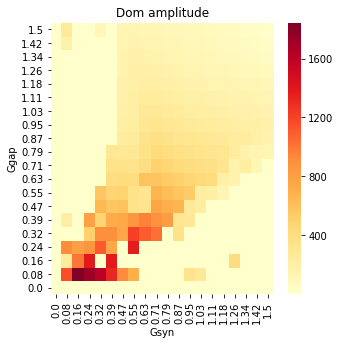

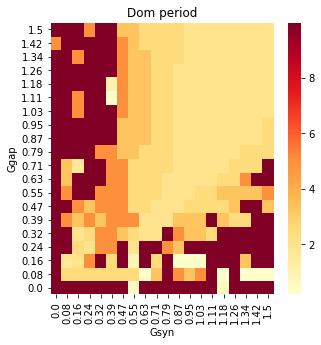

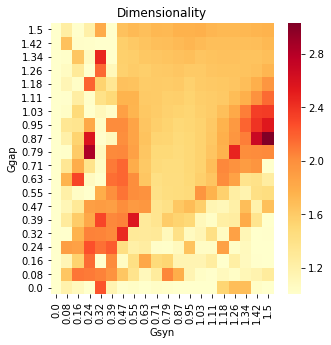

In [15]:
import seaborn as sns
import pandas as pd

def plot_heatmap(ax, ggap_vals, gsyn_vals, output_vals):
  ggap_vals = np.round(ggap_vals, 2)
  gsyn_vals = np.round(gsyn_vals, 2)
  df = pd.DataFrame.from_dict(np.array([ggap_vals,gsyn_vals,output_vals]).T)
  df.columns = ['Ggap','Gsyn','Output']
  df['Output'] = pd.to_numeric(df['Output'])
  pivotted = df.pivot('Ggap','Gsyn','Output')
  # See this for sample color palettes
  # https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/
  return sns.heatmap(pivotted,cmap='YlOrRd', ax = ax)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 5))
ax.set_title("Dom amplitude")
plot_heatmap(ax, ggap_vals, gsyn_vals, dom_amplitude_vals)
# TODO: If you want to show where the original parameter is
# ax.scatter(10.0, 10.0, c='blue')
# Seaborn for some reason inverts the y-axis, so need to un-invert.
ax.invert_yaxis()
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 5))
ax.set_title("Dom period")
plot_heatmap(ax, ggap_vals, gsyn_vals, dom_period_vals)
ax.invert_yaxis()
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 5))
ax.set_title("Dimensionality")
_ = plot_heatmap(ax, ggap_vals, gsyn_vals, dimensionality_vals)
ax.invert_yaxis()

  